# Working with Custom Images

So far everything we've worked with has been nicely formatted for us already by Keras.

Let's explore what its like to work with a more realistic data set.

--------

ORIGINAL DATA SOURCE:

https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

-----------

The Kaggle Competition: [Cats and Dogs](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) includes 25,000 images of cats and dogs. We will be building a classifier that works with these images and attempt to detect dogs versus cats!

The pictures are numbered 0-12499 for both cats and dogs, thus we have 12,500 images of Dogs and 12,500 images of Cats. This is a huge dataset!!

--------
----------
------------


**Note: We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches. **

### Visualizing the Data


-------

In [1]:
import matplotlib.pyplot as plt
import cv2
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [2]:
cat4 = cv2.imread('../DATA/CATS_DOGS/train/CAT/4.jpg')
cat4 = cv2.cvtColor(cat4,cv2.COLOR_BGR2RGB)

In [3]:
type(cat4)

numpy.ndarray

In [4]:
cat4.shape

(375, 500, 3)

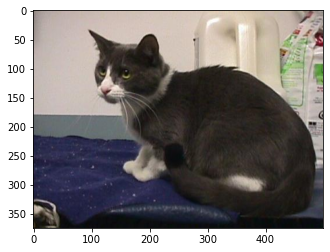

In [5]:
plt.imshow(cat4)

In [6]:
dog2 = cv2.imread('../DATA/CATS_DOGS/train/Dog/2.jpg')
dog2 = cv2.cvtColor(dog2,cv2.COLOR_BGR2RGB)

In [7]:
dog2.shape

(199, 188, 3)

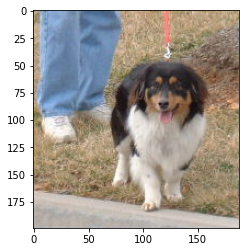

In [8]:
plt.imshow(dog2)

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [10]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

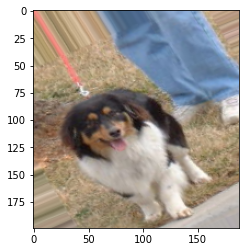

In [11]:
plt.imshow(image_gen.random_transform(dog2))

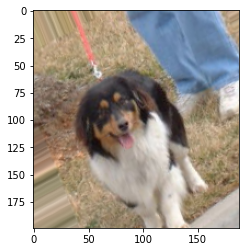

In [12]:
plt.imshow(image_gen.random_transform(dog2))

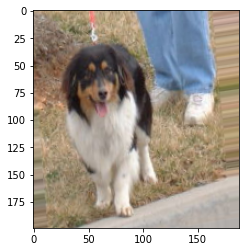

In [13]:
plt.imshow(image_gen.random_transform(dog2))

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [14]:
image_gen.flow_from_directory('../DATA/CATS_DOGS/train')

Found 18743 images belonging to 2 classes.


In [15]:
image_gen.flow_from_directory('../DATA/CATS_DOGS/test')

Found 6251 images belonging to 2 classes.


### Resizing Images

Let's have Keras resize all the images to 150 pixels by 150 pixels once they've been manipulated.

In [16]:
# width,height,channels
image_shape = (150,150,3)

# Creating the Model

In [17]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary, 0=cat , 1=dog
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

### Training the Model

In [20]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('../DATA/CATS_DOGS/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 18743 images belonging to 2 classes.


In [21]:
test_image_gen = image_gen.flow_from_directory('../DATA/CATS_DOGS/test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 6251 images belonging to 2 classes.


In [22]:
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
results = model.fit_generator(train_image_gen,epochs=20,
                              steps_per_epoch=150,
                              validation_data=test_image_gen,
                             validation_steps=12)

Epoch 1/20
150/150 [==============================] - 52s 348ms/step - loss: 0.6915 - accuracy: 0.5387 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/20
150/150 [==============================] - 52s 348ms/step - loss: 0.6833 - accuracy: 0.5663 - val_loss: 0.6728 - val_accuracy: 0.6302
Epoch 3/20
150/150 [==============================] - 49s 329ms/step - loss: 0.6733 - accuracy: 0.5883 - val_loss: 0.6476 - val_accuracy: 0.6198
Epoch 4/20
150/150 [==============================] - 49s 327ms/step - loss: 0.6817 - accuracy: 0.5783 - val_loss: 0.6779 - val_accuracy: 0.5260
Epoch 5/20
150/150 [==============================] - 46s 306ms/step - loss: 0.6657 - accuracy: 0.5967 - val_loss: 0.6483 - val_accuracy: 0.6615
Epoch 6/20
150/150 [==============================] - 46s 304ms/step - loss: 0.6495 - accuracy: 0.6350 - val_loss: 0.5968 - val_accuracy: 0.6927
Epoch 7/20
150/150 [==============================] - 46s 304ms/step - loss: 0.6360 - accuracy: 0.6425 - val_loss: 0.6377 - val_ac

In [33]:
# model.save('cat_dog2.h5')

# Evaluating the Model

In [26]:
results.history

{'loss': [0.6914582848548889,
  0.6833345293998718,
  0.6733165979385376,
  0.6816854476928711,
  0.6657494902610779,
  0.6494839191436768,
  0.6359996795654297,
  0.6256905198097229,
  0.6323115229606628,
  0.6077827215194702,
  0.5894925594329834,
  0.5971336364746094,
  0.5839923620223999,
  0.5836122035980225,
  0.5803676843643188,
  0.5854065418243408,
  0.5606979131698608,
  0.5436042547225952,
  0.5590821504592896,
  0.5378566384315491],
 'accuracy': [0.5387499928474426,
  0.5662500262260437,
  0.5883333086967468,
  0.57833331823349,
  0.596666693687439,
  0.6349999904632568,
  0.6424999833106995,
  0.6575000286102295,
  0.6470096111297607,
  0.6704166531562805,
  0.6858333349227905,
  0.6829166412353516,
  0.6920833587646484,
  0.6924999952316284,
  0.6974999904632568,
  0.6929166913032532,
  0.7129166722297668,
  0.7120833396911621,
  0.7099999785423279,
  0.7300000190734863],
 'val_loss': [0.6910247802734375,
  0.672785758972168,
  0.6476204991340637,
  0.6778934597969055,
  

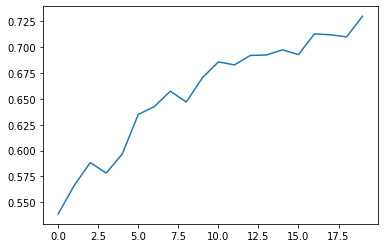

In [34]:
plt.plot(results.history['accuracy'])

In [35]:
model.save('cat_dog_20epochs.h5')

# Predicting on new images

In [36]:
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

In [78]:
import numpy as np
from keras.preprocessing import image

dog_file = '../DATA/CATS_DOGS/test/DOG/9374.jpg'

dog_img = image.load_img(dog_file, target_size=(150, 150))

dog_img = image.img_to_array(dog_img)

dog_img = np.expand_dims(dog_img, axis=0)
dog_img = dog_img/255

In [79]:
prediction_prob = model.predict(dog_img)

In [80]:
# Output prediction
print(f'Probability that image is a dog is: {prediction_prob} ')

Probability that image is a dog is: [[0.53170824]] 


* If you have already trained model, you can use that model in this way
*Let's look at the 100 epochs model which is more accurate we assume for same random picture

In [81]:
from keras.models import load_model

trained_model = load_model('cat_dog_100epochs.h5')

In [82]:
dog_file = '../DATA/CATS_DOGS/test/DOG/9374.jpg'

In [83]:
dog_img = image.load_img(dog_file, target_size=(150,150))

In [84]:
dog_img = image.img_to_array(dog_img)

In [85]:
dog_img.shape

(150, 150, 3)

In [86]:
dog_img = np.expand_dims(dog_img, axis=0)

In [87]:
dog_img = dog_img/dog_img.max()

In [90]:
trained_model.predict_classes(dog_img)

array([[1]])

In [91]:
trained_model.predict(dog_img)

array([[0.89676845]], dtype=float32)

* As we can see, when 20 epochs model has 0.531 accuracy, there is 0.896 accuracy for 100 epochs model.